# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head())
print()
print(data.info())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

### Вывод

Датасет имеет 23699 строк и 22 колонки с данными, состоящих из информации указанных в объявлениях о продаже квартир в Санкт-Петербурге и в соседних населенных пунктах (количество этажей в доме, высота потолков, площадь кухни и др.). На первый взгляд можно отметить наличие пропусков в некоторых столбцах: высота потолков - возможно, не указаны в объявлении тем, кто его размещал; жилая площадь - скорее всего, не указано из-за того, не указана площадь кухни или объект является студией; в столбце is_apartment есть пропуски из-за того, что в столбце указывается сам факт наличия, соответственно все пропуски - это подтвержение факта отсутствия данного признака, будем считать NaN в is_apartment как не апартаменты; пропуски в столбце balcony указывают на отсутствие балкона в квартире/студии; пропуски в столбцах, указывающих на растояние до объекта, возможно, появились вследствии того, что эти данные не были указаны в объявлении. Так же встречается неверный тип данных в некоторых столбцах, например, last_price явно целочисленное значение и должно иметь тип данных int64, столбец first_day_exposition содержит в себе дату размещения объявления, соответственно вместо типа object должен бытть тип datetime64, а столбец is_apartment должен иметь bool тип в связи с тем, что столбец отвечает на вопрос апартаменты ли это, с ответом "да" (True) и "нет" (False), также необходимо заменить тип данных в столбцах floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.

### Шаг 2. Предобработка данных

In [186]:
print(data.duplicated().sum())
print()
print(data.isna().sum())

0

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Проверяя данные следует отметить, что дубликатов не обнаружено, следует заменить пропущенные значения. В столбце is_apartment заменим пропуски на False, тем самым укажем, объект не является апартаментами. Пропуски в столбцах living_area и  ceiling_height заменим медианным значением, на наш взягляд это релевантно. В столбцах floors_total и locality_name имеется незначительное количество пропущенных значений от общего объема данных - 0,004% и 0,002% соответственно, поэтому удалим строки содержащие пропуски в этих столбцах. В столбце kitchen_area заменим проопущенные значения для студий нулем, для всех остальных объектов - медианным значением. Пропуски в balcony заменим нулем, объявляя тем самым отсутствие балкона в данном объекте недвижимости. Пропуски обнаруженные в других столбцах не имеет смысла заменять на мединаные и средние значения ввиду последующего искажения данных, данные пропуски заменим на 0 и в дальнейшем учтем это при анализе данных в заимосвязях.

In [188]:
data['is_apartment'] = data['is_apartment'].fillna(False)

ceiling_height_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median)

data.dropna(subset = ['floors_total'], inplace = True)
data.dropna(subset = ['locality_name'], inplace = True)

living_area_median = data['living_area'].median()
data['living_area'] = data['living_area'].fillna(living_area_median)

data.query('studio==True')['kitchen_area'].fillna(value=0, inplace=True)
data.query('studio==True')['kitchen_area'].isna().sum()
data.loc[data['studio'] & data['kitchen_area'].isna(), 'kitchen_area'] = 0.0
kitchen_area_median = data['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_area_median)

data['balcony'] = data['balcony'].fillna(0)

data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_nearest'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_nearest'] = data['parks_around3000'].fillna(0)
data['days_exposition'] = data['days_exposition'].fillna(0)

In [189]:
print(data.isna().sum())

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64


Все пропуски успешно заменены наиболее подходящими значениями, теперь изменим тип данных.

In [190]:
data = data.astype({"last_price":'int64',
                    "floors_total":'int64',
                    "balcony":'int64',
                    "airports_nearest":'int64',
                    "cityCenters_nearest":'int64',
                    "parks_around3000":'int64',
                    "parks_nearest":'int64',
                    "ponds_around3000":'int64',
                    "ponds_nearest":'int64',
                    "days_exposition":'int64',
                    "ceiling_height":'int64'})

data['living_area'] = pd.to_numeric(data['living_area'], errors='coerce')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null int64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null int64
floors_total            23565 non-null int64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        23565 non-null int64
cityCenters_nearest     23565 non-null int64
parks_around3000        23565 non-null int64
parks_nearest           23565 non-null int64
ponds_around3000       

Замена типа данных завершена, каждый столбец теперь соответствует требованиям обозначенным в начале проекта.
Все целочисленные значения переведены в тип данных int64 (такие как количество комнат, количество этажей, последняя цена), а нецелочисленные приведены к типу данных float64 (площади). Оставлены без изменения булевы данные (is_apartment, studio, open_plan), а также данные о названии населенного пункта locality_name с типом данных object.

### Шаг 3. Посчитайте и добавьте в таблицу

Добавим в таблицу столбец, содержащий стоимость квадратного метра.

In [191]:
data['price_per_meter'] = data['last_price']/data['total_area']

Добавим столбцы с днем недели, месяцем и годом пуликации объявления

In [192]:
data['day_of_week'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Добавим словесное описание этажа, на котором располагается объект (первый, последний, другой)

In [193]:
def what_floor(row):
    f_t = row['floors_total']
    f = row['floor']
    if 1 == f:
        return '1. первый'
    if f_t == f:
        return '3. последний'
    else:
        return '2. другой'
    
data['what_floor'] = data.apply(what_floor, axis = 1)

Добавим соотношение жилой площади к общей и соотношение площади кухни к общей площади.

In [194]:
data['living_total_area_ratio'] = data['living_area']/data['total_area']
data['kitchen_total_area_ratio'] = data['kitchen_area']/data['total_area']

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64
52.0


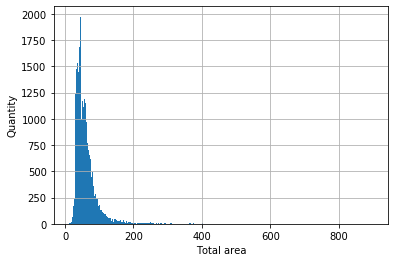

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64
4646000.0


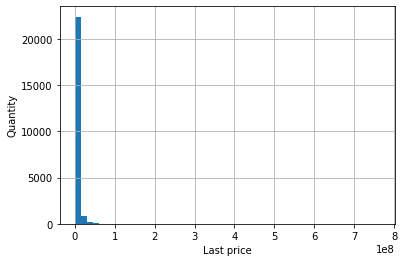

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
2.0


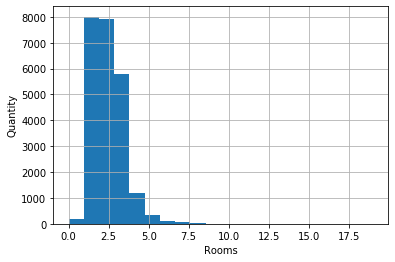

count    23565.000000
mean         2.142839
std          1.036042
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        100.000000
Name: ceiling_height, dtype: float64
2.0


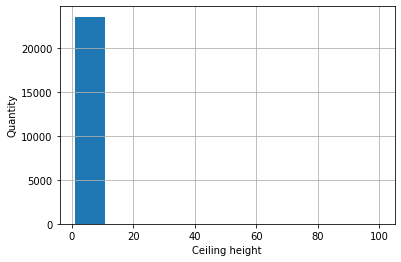

In [195]:
print(data['total_area'].describe())
print(data['total_area'].median())
data['total_area'].hist(bins=300, range=(11, 901))
plt.xlabel('Total area')
plt.ylabel('Quantity')
plt.show()

print(data['last_price'].describe())
print(data['last_price'].median())
data['last_price'].hist(bins=50, range=(12000, 763000001))
plt.xlabel('Last price')
plt.ylabel('Quantity')
plt.show()

print(data['rooms'].describe())
print(data['rooms'].median())
data['rooms'].hist(bins=20, range=(0, 19))
plt.xlabel('Rooms')
plt.ylabel('Quantity')
plt.show()

print(data['ceiling_height'].describe())
print(data['ceiling_height'].median())
data['ceiling_height'].hist(bins=10, range=(1, 100))
plt.xlabel('Ceiling height')
plt.ylabel('Quantity')
plt.show()

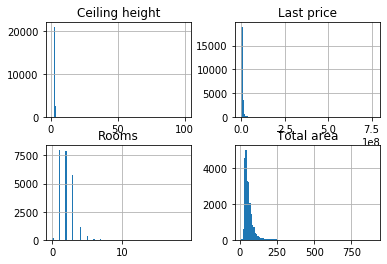

In [196]:

df=pd.DataFrame({'Total area':data['total_area'],'Last price':data['last_price'],'Rooms':data['rooms'],'Ceiling height':data['ceiling_height']}, columns=['Total area', 'Last price', 'Rooms', 'Ceiling height'])
ax = df.hist(bins=100)
plt.show()


Средняя площадь размещаемых объектов недвижимости равна 60,32 квадратных метра, а медианное - 52 квадратных метра. Минимальная площадь при этом 12 квадратных метров. а макисмальная - 900 квадратных метров, что говорит о достаточно большом разбросе анализируемых значений. Гистограмма. построенная на данных о площади жилья имеет нормальное распределение, но имеются так же и выбросы, так например, аномальными, на первый взгляд, представляются значения свыше 190 квадратных метров, их количество мало в сравнении с другими значениями. 

Стоимость анализируемых объектов в среднем составляет 6540 тыс. рублей, что близко к медианному значению стоимости - 4646 тыс. рублей. Разброс значений стоимости достаточно большой (минимальное - 12190 рублей, и максимальное - 763 млн. рублей), так же странным значением кажется минимальная стоимость объекта, всего 12190 рублей, скорее всего это значение является выбросом. Гистограмма, построенная на данных о стоимости недвижимости имеет распределение Пуассона, и не дает явного представления о данных.

Количество комнат в анализируемых объявлений в среднем на один объект равно двум, что равно и медианному значению. Минимальное количество комнат - 0, то есть квартиры-студии или со свободной планировкой. Максимальное - 19 комнат. Гистограмма имеет нормальное распределение.

Говоря о данных о высоте потолков отметим, что минимальное значение - 1 метр, что скорее не реально, а максимальное - 100 метров, что так же представялется нереальным, скорее всего это выбросы, некорректно заполненные графы в объявлениях.

Изучим время продажи квартиры и построим гистограмму, найдем среднее и медиану.

Медиана = 73.0
count    23565.000000
mean       156.420115
std        213.517293
min          0.000000
25%         22.000000
50%         73.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64


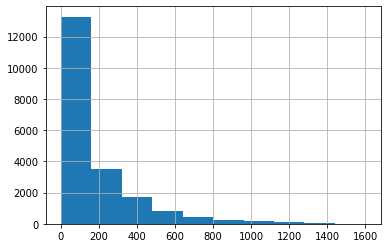

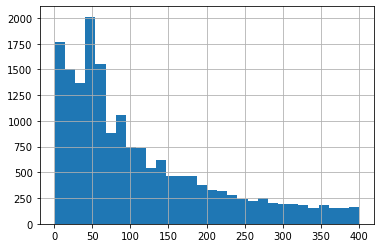

In [198]:
print('Медиана =', data['days_exposition'].median())
print(data['days_exposition'].describe())
data['days_exposition'].hist(bins=10, range=(1, 1600))
plt.show()
data['days_exposition'].hist(bins=30, range=(1, 400))
plt.show()

Обычно продажа занимает от 45 до 60 дней. Продажа прошла быстро в том случае, с момента публикации объявление до снятия прошло до 22 дней, медленно - свыше 200 дней. Среднее значение - 156 дней. медианное - 73 дня.

Уберем редкие и выбивающиеся значения.

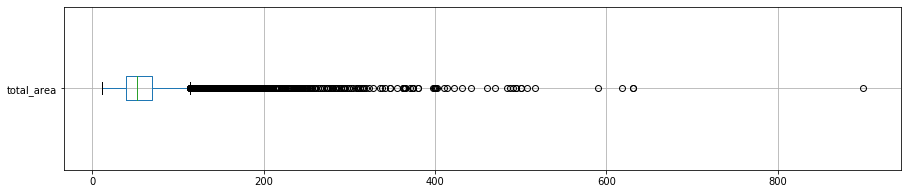

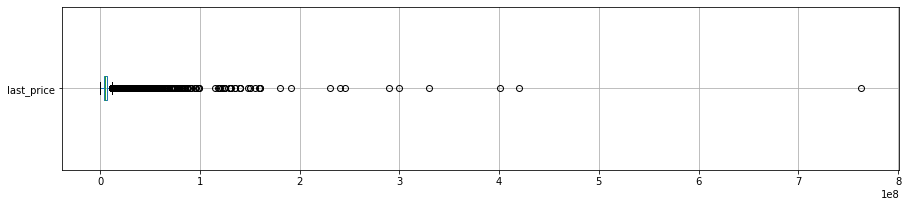

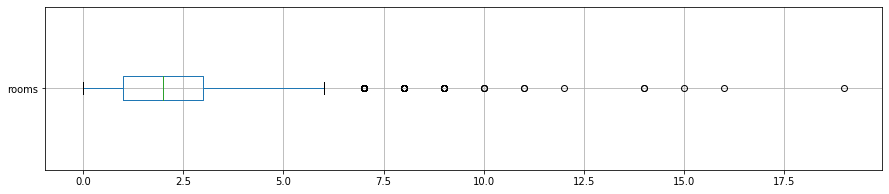

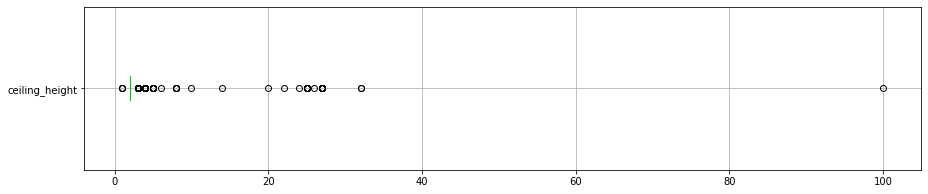

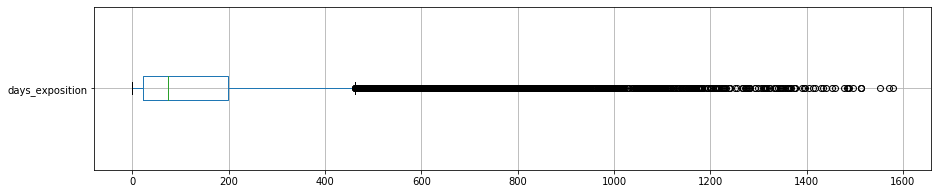

In [199]:
a = data.boxplot('total_area', vert=False, figsize=(15, 3), return_type='dict')
plt.show()
b = data.boxplot('last_price', vert=False, figsize=(15, 3), return_type='dict')
plt.show()
c = data.boxplot('rooms', vert=False, figsize=(15, 3), return_type='dict')
plt.show()
d = data.boxplot('ceiling_height', vert=False, figsize=(15, 3), return_type='dict')
plt.show()
e = data.boxplot('days_exposition', vert=False, figsize=(15, 3), return_type='dict')
plt.show()

In [200]:
whiskers_a = [item.get_xdata() for item in a['whiskers']]
print(whiskers_a)
whiskers_b = [item.get_xdata() for item in b['whiskers']]
print(whiskers_b)
whiskers_c = [item.get_xdata() for item in c['whiskers']]
print(whiskers_c)
whiskers_d = [item.get_xdata() for item in d['whiskers']]
print(whiskers_d)
whiskers_e = [item.get_xdata() for item in e['whiskers']]
print(whiskers_e)

[array([40., 12.]), array([ 69.7, 114.2])]
[array([3400000.,   12190.]), array([ 6790000., 11866860.])]
[array([1., 0.]), array([3., 6.])]
[array([2., 2.]), array([2., 2.])]
[array([22.,  0.]), array([198., 462.])]


In [201]:
total_area_median = data['total_area'].median()
def n_t_a(total_area):
    global total_area_median
    if total_area < 12:
        return total_area_median
    if total_area > 114.2:
        return total_area_median
    else:
        return total_area
data['new_total_area'] = data['total_area'].apply(n_t_a)


last_price_median = data['last_price'].median()
def n_l_p(last_price):
    global last_price_median
    if last_price < 12190:
        return last_price_median
    if last_price > 11866860:
        return last_price_median
    else:
        return last_price
data['new_last_price'] = data['last_price'].apply(n_l_p)


rooms_median = data['rooms'].median()
def n_r(rooms):
    global rooms_median
    if rooms < 0:
        return rooms_median
    if rooms > 6:
        return rooms_median
    else:
        return rooms
data['new_rooms'] = data['rooms'].apply(n_r)


ceiling_height_median = data['ceiling_height'].median()
def n_c_h(ceiling_height):
    global ceiling_height_median
    if ceiling_height < 2:
        return ceiling_height_median
    if ceiling_height > 2:
        return ceiling_height_median
    else:
        return ceiling_height
data['new_ceiling_height'] = data['ceiling_height'].apply(n_c_h)


days_exposition_median = data['days_exposition'].median()
def n_d_e(days_exposition):
    global days_exposition_median
    if days_exposition < 1:
        return days_exposition_median
    if days_exposition > 462:
        return days_exposition_median
    else:
        return days_exposition
data['new_days_exposition'] = data['days_exposition'].apply(n_d_e)

Механика действий при поиске выбросов и аномальных значений: строим диаграмму размаха для каждого из параметров, она показывает какие значения можно считать нормальными, а какие - выбросами (обозначены точками). Получаем граница, в рамках которых находятся нормальные значения, затем строим новые гистограммы, отражающие нормальное распеределение данных.

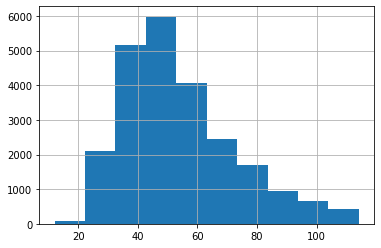

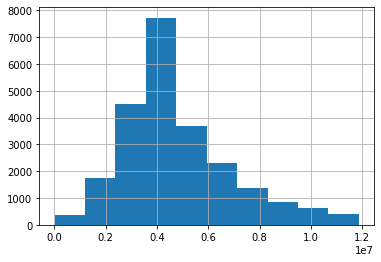

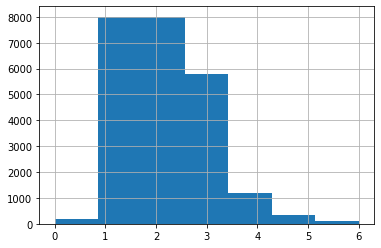

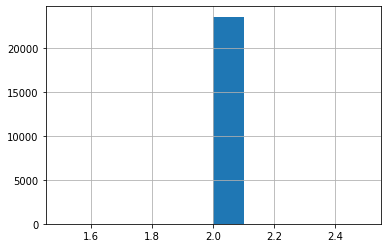

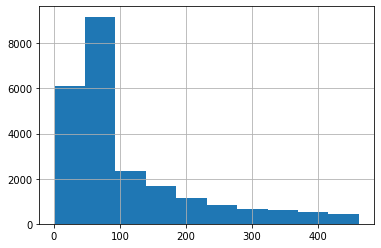

In [202]:
data['new_total_area'].hist(bins=10)
plt.show()

data['new_last_price'].hist(bins=10)
plt.show()

data['new_rooms'].hist(bins=7)
plt.show()

data['new_ceiling_height'].hist(bins=10)
plt.show()

data['new_days_exposition'].hist(bins=10)
plt.show()

При анализе можно отметить, что обнаружены характерные выбросы и редкие значения в данных о площади, наверняка, они реальны, просто выбиваются из общего числа, равно как и данные о стоимости - выбросов также достаточно много (чем больше квадратных метров, тем больше стоимость недвижимости - закономерно). Из-за значения в 100 метров считаем неадекватным анализ параметра высоты потолков, физически не может быть такой большой высоты, ровно как и значения 7 метров и выше. В целом данные обрели нормальный вид и имеют нормальное распределение.

Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, удалённости от центра. Изучите зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучите зависимость от даты размещения: дня недели, месяца и года.

In [203]:
print(data['new_last_price'].corr(data['new_total_area']))
print(data['new_last_price'].corr(data['new_rooms']))
print(data['new_last_price'].corr(data['cityCenters_nearest']))

res_nlp_floor = data.pivot_table(index = 'what_floor', values = 'new_last_price')
res_nlp_floor.style.format("{}")


0.5999853784522478
0.38171643978598
0.10935021788441357


,new_last_price
what_floor,
1. первый,4145755.597799931
2. другой,4995788.844280273
3. последний,4498061.080480481


Анализируя взаимосвязь данных о стоимости недвижимости с другими параметрами можно обозначить, что в большей степени на стоимость объекта влияет площадь этого объекта, другими словами, чем больше площадь, тем больше стоимость объекта. Количество комнат и удаленность от центра также положительно сказываются на увеличение стоимости объекта.

Что примечательно, средняя стоимость объектов на первом и последнем этажах сопоставима и отличается от стоимости объектов, размещенных на других этажах. Таким образом квартиры на первом и последнем этажах дешевле, чем квартира ну любом другом этаже.

In [204]:
res_nlp_day = data.pivot_table(index = 'day_of_week', values = 'new_last_price')
res_nlp_day.style.format("{}")

,new_last_price
day_of_week,
0,4820269.350111235
1,4875341.313956281
2,4849489.12993921
3,4825857.238774556
4,4802025.61080402
5,4723163.590411672
6,4758697.549613785


Анализируя данные, не удается выявить существенную разницу в стоимости объекта в зависимости от дня недели, в которое было размещено объявление.

In [205]:
res_nlp_month = data.pivot_table(index = 'month', values = 'new_last_price')
res_nlp_month.style.format("{}")

,new_last_price
month,
1,4778459.872898453
2,4818416.191198786
3,4783238.682330097
4,4918339.786926995
5,4792602.639175258
6,4672643.574127075
7,4815895.353499407
8,4821010.987924094
9,4925519.415821501


Также не удается выявить существенную разницу в стоимости объекта в зависимости от месяца года, в котором было размещено объявление.

In [206]:
res_nlp_year = data.pivot_table(index = 'year', values = 'new_last_price')
res_nlp_year.sort_values(by = 'new_last_price', ascending = False).style.format("{}")

,new_last_price
year,
2014,5389696.661764706
2015,5150727.496569469
2019,5053692.228143504
2016,4778324.312568306
2018,4764145.897242517
2017,4754643.331944615


Не удается так же выявить взаимосвязи цены объекта и годом размещения этого объекта на продажу.

Таким образом, существенное влияние на стоимость недвижимости оказывает площадь этой недвижимости, и исходя из этого количество комнат. Меньшее значение имеет дата размещения объекта на сайт.

Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [207]:
import re

replace_set = {'посёлок', 'село', 'поселок', 'городского', 'типа', 'деревня', 'садовое', 'товарищество', 'городской', 'при', 'железнодорожной', 'станции', 'коттеджный', 'садоводческое', 'некоммерческое'}
data['new_locality_name'] = data['locality_name'].str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in replace_set))

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,year,what_floor,living_total_area_ratio,kitchen_total_area_ratio,new_total_area,new_last_price,new_rooms,new_ceiling_height,new_days_exposition,new_locality_name
0,20,13000000,108.0,2019-03-07,3,2,16,51.0,8,False,...,2019,2. другой,0.472222,0.231481,108.0,4646000.0,3.0,2.0,73.0,Санкт-Петербург
1,7,3350000,40.4,2018-12-04,1,2,11,18.6,1,False,...,2018,1. первый,0.460396,0.272277,40.4,3350000.0,1.0,2.0,81.0,Шушары
2,10,5196000,56.0,2015-08-20,2,2,5,34.3,4,False,...,2015,2. другой,0.612500,0.148214,56.0,5196000.0,2.0,2.0,73.0,Санкт-Петербург
3,0,64900000,159.0,2015-07-24,3,2,14,30.0,9,False,...,2015,2. другой,0.188679,0.056604,52.0,4646000.0,3.0,2.0,424.0,Санкт-Петербург
4,2,10000000,100.0,2018-06-19,2,3,14,32.0,13,False,...,2018,2. другой,0.320000,0.410000,100.0,10000000.0,2.0,2.0,121.0,Санкт-Петербург


При первом рассмотрении столбца locality_name обнаружили по разному записанные имена одного и того же населенного пункта, например - поселок Мурино, посёлок Мурино и Мурино. Наличие этих недостатков не позволит корректно посчитать число объявлений на населенный пункт, поэтому мы исключили слова, обозначающие тип населенного пункта, оставив само название.

In [208]:
data['new_locality_name'].unique()
data.groupby('new_locality_name').count().sort_values(by= 'total_images', ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,month,year,what_floor,living_total_area_ratio,kitchen_total_area_ratio,new_total_area,new_last_price,new_rooms,new_ceiling_height,new_days_exposition
new_locality_name,,,,,,,,,,,,,,,,,,,,,
Санкт-Петербург,15651,15651,15651,15651,15651,15651,15651,15651,15651,15651,...,15651,15651,15651,15651,15651,15651,15651,15651,15651,15651
Мурино,586,586,586,586,586,586,586,586,586,586,...,586,586,586,586,586,586,586,586,586,586
Кудрово,470,470,470,470,470,470,470,470,470,470,...,470,470,470,470,470,470,470,470,470,470
Шушары,439,439,439,439,439,439,439,439,439,439,...,439,439,439,439,439,439,439,439,439,439
Всеволожск,398,398,398,398,398,398,398,398,398,398,...,398,398,398,398,398,398,398,398,398,398
Пушкин,369,369,369,369,369,369,369,369,369,369,...,369,369,369,369,369,369,369,369,369,369
Колпино,338,338,338,338,338,338,338,338,338,338,...,338,338,338,338,338,338,338,338,338,338
Парголово,327,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,327,327,327
Гатчина,307,307,307,307,307,307,307,307,307,307,...,307,307,307,307,307,307,307,307,307,307


Таким образом, определили топ-10 населенных пунктов по количеству размещенных объявлений.

In [209]:
data['new_price_per_meter'] = data['new_last_price']/data['new_total_area']
res_ppm_ln = data.pivot_table(index = 'new_locality_name', values = 'new_price_per_meter')
res_ppm_ln.query("new_locality_name == ['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг']").sort_values(by= 'new_price_per_meter', ascending=False)

,new_price_per_meter
new_locality_name,
Санкт-Петербург,102075.533470
Пушкин,98731.550759
Кудрово,94996.321536
Парголово,90520.614136
Мурино,86041.116064
Шушары,79236.988012
Колпино,75408.490787
Гатчина,68800.966102
Всеволожск,68123.832930


Анализируя среднюю стоимость топовых по количеству объявлений населенных пунктов можно отметить, что наибольшая цена квадратного метра зафиксирована в Санкт-Петербурге, в городе Пушкине и в Кудрове - 100 тыс. рублей за квадратный метр. Самая низкая из анализируемых населенных пунктов зафиксирована в Выборге - 60,5 тыс. рублей за квадратный метр.

Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

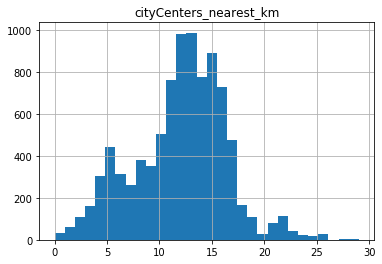

In [210]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest']/1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round()
data_spb = data.query("new_locality_name == ['Санкт-Петербург']")
data_spb.pivot_table(index = 'new_price_per_meter', values = 'cityCenters_nearest_km').hist(bins=30)
plt.show()

Центральная зона расположена в промежутке от 1 до 3 км от центра Санкт-Петербурга. 

Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [211]:
data_spb = data_spb.query("cityCenters_nearest_km == [1, 2, 3]")
print('Медианная площадь:', data_spb['new_total_area'].median())
print('Средняя площадь:', data_spb['new_total_area'].mean())
print('Минимальная площадь:', data_spb['new_total_area'].min())
print('Максимальная площадь:', data_spb['new_total_area'].max())
print()
print('Медианная цена:', data_spb['new_last_price'].median())
print('Средняя цена:', data_spb['new_last_price'].mean())
print('Минимальная цена:', data_spb['new_last_price'].min())
print('Максимальная цена:', data_spb['new_last_price'].max())
print()
print('Медианное число комнат:', data_spb['new_rooms'].median())
print('Среднее число комнат:', data_spb['new_rooms'].mean())
print('Минимальное число комнат:', data_spb['new_rooms'].min())
print('Максимальное число комнат:', data_spb['new_rooms'].max())
print()
print('Медианная высота потолков:', data_spb['new_ceiling_height'].median())
print('Средняя высота потолков:', data_spb['new_ceiling_height'].mean())
print('Минимальная высота потолков:', data_spb['new_ceiling_height'].min())
print('Максимальная высота потолков:', data_spb['new_ceiling_height'].max())

Медианная площадь: 62.3
Средняя площадь: 67.43995294117647
Минимальная площадь: 12.0
Максимальная площадь: 114.2

Медианная цена: 5695000.0
Средняя цена: 6555474.9388235295
Минимальная цена: 2100000.0
Максимальная цена: 11840000.0

Медианное число комнат: 3.0
Среднее число комнат: 2.94
Минимальное число комнат: 0.0
Максимальное число комнат: 6.0

Медианная высота потолков: 2.0
Средняя высота потолков: 2.0
Минимальная высота потолков: 2.0
Максимальная высота потолков: 2.0


Сравнивая данные по всему городу с данными центральной зоны можно отметить, что значительной разницы не обнаружено. Существенные различия можно отметить только по параметру медианной площади и медианной стоимости объекта: 62,3 кв.м , в отличие от 52 кв.м. по всему городу и 5,7 млн рублей за квартиру в центре и 4,6 млн рублей в целом по городу, а также максимальная стоимость объекта: в центральной зоне - 11,9 млн руб., а по всему городу 763 млн. рублей. 

In [212]:
print(data_spb['new_last_price'].corr(data_spb['new_total_area']))
print(data_spb['new_last_price'].corr(data_spb['new_rooms']))
print(data_spb['new_last_price'].corr(data_spb['cityCenters_nearest']))

res_nlp_floor_spb = data_spb.pivot_table(index = 'what_floor', values = 'new_last_price')
res_nlp_floor_spb.style.format("{}")


0.3668405102821979
0.030501183736728745
-0.007009791270186354


,new_last_price
what_floor,
1. первый,6099950.798387097
2. другой,6550568.844230769
3. последний,6842058.252427184


Важнейшим фактором ценообразования является площадь объекта, как и в анализе по всему городу, этот параметр в стоимости жилья в центральной зоне имеет превалирующие значение (коррелируются на уровне 0,6 и 0,36 сооветственно). Так же как и по всему городу, не маловажно количество комнат. Тогда как удаленность от центра в центральной зоне играет не имеет такого сильного влияния на цену объекта, в отличие от корреляции по всему городу. 

В отличие от всего города в центральной части стоимость квартир выше на последнем этаже, чем на первом и других, тогда как по всему городу более дорогие - не первые и не последние этажи многоквартирного дома.

In [213]:
res_nlp_day_spb = data_spb.pivot_table(index = 'day_of_week', values = 'new_last_price')
res_nlp_day_spb.style.format("{}")

,new_last_price
day_of_week,
0,6463326.392
1,6646367.2
2,6570728.571428572
3,6202162.162162162
4,6774648.148148148
5,6774678.553571428
6,6829210.52631579


Прямой взаимосвязи стоимости объекта в зависимости от дня недели размещения не установлено.

In [214]:
res_nlp_month_spb = data_spb.pivot_table(index = 'month', values = 'new_last_price')
res_nlp_month_spb.style.format("{}")

,new_last_price
month,
1,6305824.561403509
2,6574481.472222222
3,6849387.804878049
4,6562734.927710843
5,6601978.723404256
6,6329562.5
7,6689000.0
8,6323076.923076923
9,6922408.974358974


Не удается выделить существенные различий в стоимости объекта в зависимости от месяца публикации объявления.

In [215]:
res_nlp_year_spb = data_spb.pivot_table(index = 'year', values = 'new_last_price')
res_nlp_year_spb.style.format("{}")

,new_last_price
year,
2014,5216800.0
2015,6352058.823529412
2016,7032348.214285715
2017,6417640.705128205
2018,6514705.390041494
2019,6801829.463157895


Не удается также выделить взаимосвязи стоимости недвижимости на год размещения объявления о ее продаже. Но так же можно и предположить, что в 2014 году средняя стоимость была ниже из-за наступившего тогда экономического кризиса, в следствие чего спрос на недвижимость в центре снизился. Далее ситуация примерно стабильная.

### Шаг 5. Общий вывод

В данном прокте мы исследовали объявления о продаже квартир в Санкт-Петербурге и соседних населенных пунктах. Была проведена оценка данных, удавлены пропущенные значения, установлен корректный тип данных для значений каждого столбца. В ходе исследования были изучены такие параметры как площадь, цена, число комнат, этажность, дата размещения и их влияние на стоимость размещаемой недвижимости. Провели два анализа - по всему городу Санкт-Петербургу и его центральной зоны, сопоставили выводы по каждому из параметров. Подводя итог, стоит отметить что существенным параметром при формировании цены недвижимости как во всем городе, так и в центральной зоне является общая площадь объекта недвижимости, причем в центральной зоне это прослеживается в большей степени. Не далось установить взаимосвязи между датой размещения и стоимостью недвижимости в целом по городу, но в центральной зоне удалось выявить небольшую взаимосвязь по месяцу и году размещения объявления о продаже. Удалось так же выявить, что стоимость квадратного метра на первом и последнем этажах как в целом по городу, так и по центральной зоне дешевле, чем на других этажах. Подводя итог, недвижимость в центральной зоне имеет больше параметров, влияющих на ценообразование, так как в основном в центральной зоне размещена элитная недвижимость.